1. Configuração e Carregamento dos Dados


In [26]:
# Célula 1: Instalação de bibliotecas (se necessário)
!pip install statsmodels optuna

# Célula 2: Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import optuna

# Bibliotecas de Análise de Séries Temporais
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

2. Carregamento e Preparação dos Dados (do seu BigQuery)


Dados carregados com sucesso do BigQuery!
O DataFrame tem 208853 linhas e 3 colunas.

Análise focada na bacia: TOCANTINS
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9398 entries, 2000-01-01 to 2025-09-23
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ena_armazenavel  9398 non-null   float64
dtypes: float64(1)
memory usage: 146.8 KB
None


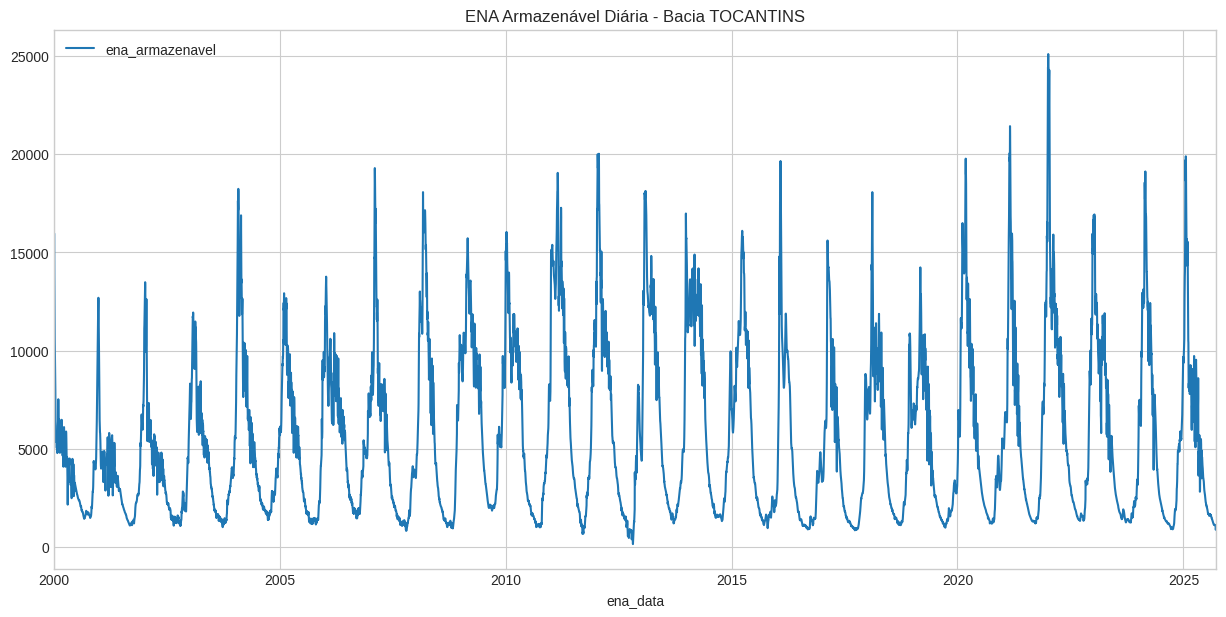

In [27]:
# Célula 3: Autenticação e conexão com o BigQuery
from google.colab import auth
auth.authenticate_user()

project_id = 'sauter-university-472416'
client = bigquery.Client(project=project_id)

# Célula 4: Query para buscar os dados da tabela ena_basin_silver
sql_query = """
SELECT
    nom_bacia,
    ena_data,
    ena_armazenavel_bacia_mwmed
FROM
    `sauter-university-472416.ons_silver.ena_basin_silver`
ORDER BY
    ena_data
"""

df_total = client.query(sql_query).to_dataframe()
print("Dados carregados com sucesso do BigQuery!")
print(f"O DataFrame tem {df_total.shape[0]} linhas e {df_total.shape[1]} colunas.")

# Célula 5: Preparação e Limpeza dos Dados
# Converter a coluna de data para datetime e definir como índice
df_total['ena_data'] = pd.to_datetime(df_total['ena_data'])
df_total.set_index('ena_data', inplace=True)
df_total.sort_index(inplace=True)

# Converter a coluna alvo para numérico
df_total['ena_armazenavel_bacia_mwmed'] = pd.to_numeric(df_total['ena_armazenavel_bacia_mwmed'], errors='coerce')

# Vamos focar em uma única bacia para o modelo. Ex: PARANAPANEMA
# Você pode alterar o nome da bacia aqui para treinar outros modelos
nome_bacia = 'TOCANTINS'
df_bacia = df_total[df_total['nom_bacia'] == nome_bacia].copy()

# Selecionar e renomear nossa variável alvo
df_bacia = df_bacia[['ena_armazenavel_bacia_mwmed']].rename(columns={'ena_armazenavel_bacia_mwmed': 'ena_armazenavel'})

# Preencher valores nulos (se houver) usando o último valor válido
df_bacia.ffill(inplace=True)

print(f"\nAnálise focada na bacia: {nome_bacia}")
print(df_bacia.info())
df_bacia.plot(title=f'ENA Armazenável Diária - Bacia {nome_bacia}')
plt.show()

3. Análise de Autocorrelação (ACF e PACF) com Lag Anual


Analisando ACF e PACF para os dados diários... Isso pode levar um momento.


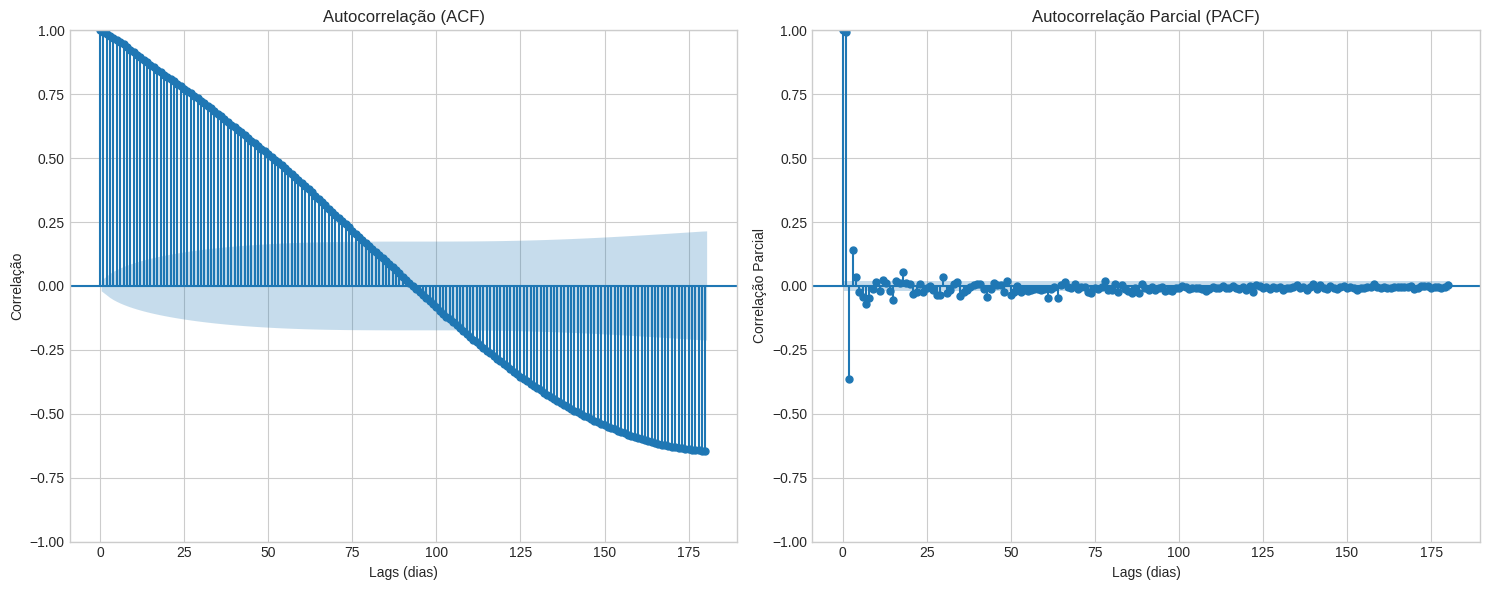

In [28]:
# Célula 6: Análise de Autocorrelação com Lag de 1 Ano (Dados Diários)

# Vamos criar um conjunto de treino com dados até o final de 2023 para a análise
treino_diario = df_bacia.loc[:'2023-12-31']

print("Analisando ACF e PACF para os dados diários... Isso pode levar um momento.")
plt.figure(figsize=(15, 6))

# Gráfico ACF
plt.subplot(1, 2, 1)
plot_acf(treino_diario['ena_armazenavel'].dropna(), ax=plt.gca(), lags=180)
plt.title('Autocorrelação (ACF)')
plt.xlabel('Lags (dias)')
plt.ylabel('Correlação')

# Gráfico PACF
plt.subplot(1, 2, 2)
plot_pacf(treino_diario['ena_armazenavel'].dropna(), ax=plt.gca(), lags=180, method='ywm')
plt.title('Autocorrelação Parcial (PACF)')
plt.xlabel('Lags (dias)')
plt.ylabel('Correlação Parcial')

plt.tight_layout()
plt.show()

4. Resampling para Dados Mensais e Otimização do SARIMA com Optuna


Agregando dados para média mensal para otimizar o SARIMA...


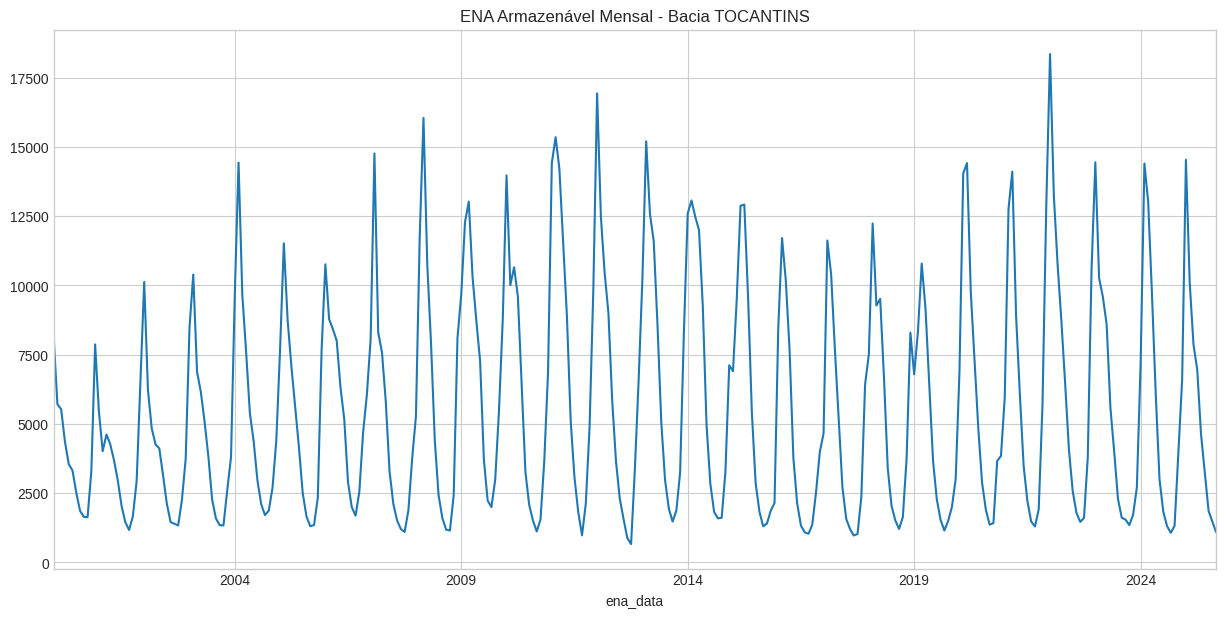

Agregando dados para média mensal...
Período de treino (mensal): 2000-01-01 a 2023-09-01
Período de teste (mensal): 2023-10-01 a 2025-09-01


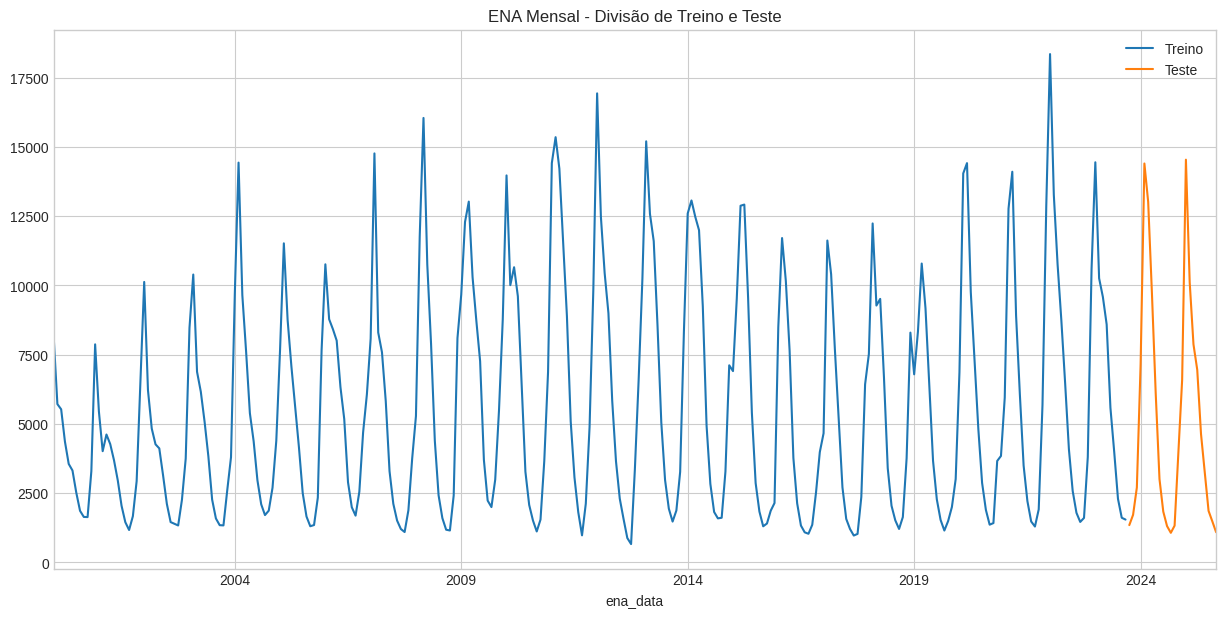

In [29]:
# Célula 7: Resampling dos dados para frequência mensal
print("Agregando dados para média mensal para otimizar o SARIMA...")
df_mensal = df_bacia['ena_armazenavel'].resample('MS').mean()
df_mensal.plot(title=f'ENA Armazenável Mensal - Bacia {nome_bacia}')
plt.show()

## Célula 8: Resampling e Divisão Treino/Teste para os modelos mensais (SARIMA e LSTM)
print("Agregando dados para média mensal...")
df_mensal = df_bacia['ena_armazenavel'].resample('MS').mean()

# Divisão Treino/Teste AJUSTADA: Usaremos os últimos 2 anos (24 meses) para teste
anos_teste = 2
meses_teste = 12 * anos_teste

treino_mensal = df_mensal[:-meses_teste]
teste_mensal = df_mensal[-meses_teste:]

print(f"Período de treino (mensal): {treino_mensal.index.min().date()} a {treino_mensal.index.max().date()}")
print(f"Período de teste (mensal): {teste_mensal.index.min().date()} a {teste_mensal.index.max().date()}")


plt.figure(figsize=(15, 7))
treino_mensal.plot(label='Treino', legend=True)
teste_mensal.plot(label='Teste', legend=True)
plt.title('ENA Mensal - Divisão de Treino e Teste')
plt.show()



5. Divisão dos Dados (Treino e Teste)


**Reasoning**:
Convert the date column to datetime and set it as the index for time series plotting.



Iniciando otimização com Optuna (50 tentativas)...


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


Otimização concluída!
Melhores parâmetros para SARIMA: {'p': 3, 'd': 0, 'q': 3, 'P': 2, 'D': 0, 'Q': 2}

Treinando o modelo SARIMA final...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



--- Métricas de Avaliação do Modelo SARIMA Otimizado ---
R² (Coeficiente de Determinação): 0.7401
Acurácia (100 - MAPE): 52.83%
MAE (Erro Absoluto Médio): 1666.10
RMSE (Raiz do Erro Quadrático Médio): 2178.58



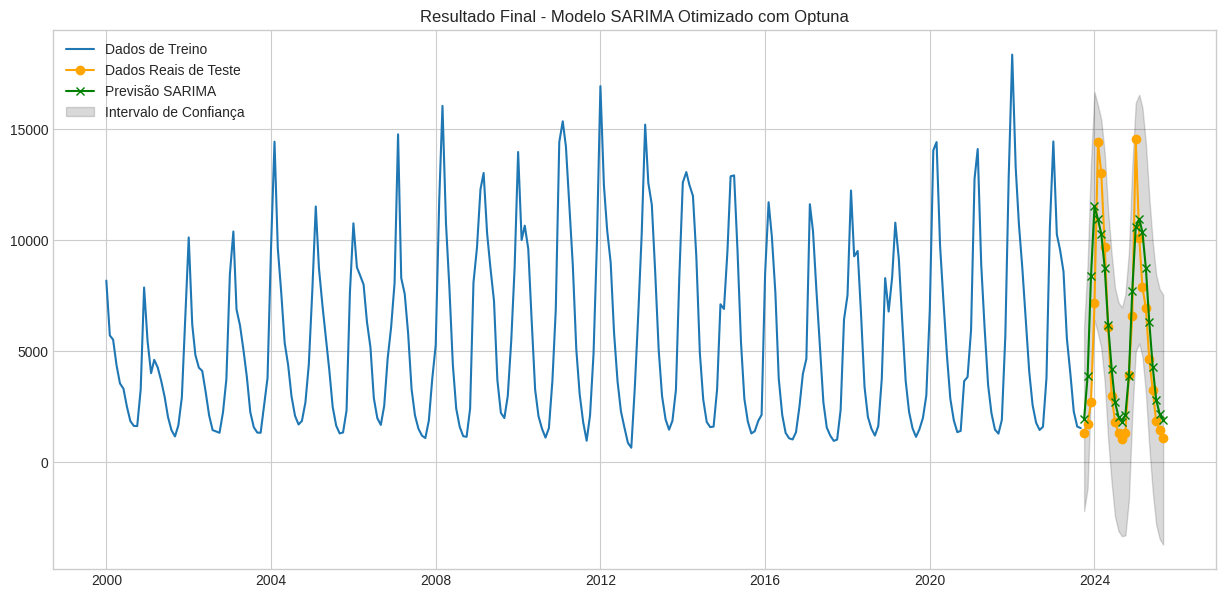

In [30]:
# Célula 9: Otimização dos Parâmetros SARIMA com Optuna
import optuna
from sklearn.metrics import mean_absolute_percentage_error

def objective_sarima(trial):
    p = trial.suggest_int('p', 0, 3)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 3)
    P = trial.suggest_int('P', 0, 2)
    D = trial.suggest_int('D', 0, 2)
    Q = trial.suggest_int('Q', 0, 2)
    s = 12

    try:
        model = SARIMAX(treino_mensal,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)
        forecast = results.get_forecast(steps=len(teste_mensal))
        forecast_mean = forecast.predicted_mean
        mse = mean_squared_error(teste_mensal, forecast_mean)
    except Exception as e:
        return float('inf')
    return mse

print("Iniciando otimização com Optuna (50 tentativas)...")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_sarima = optuna.create_study(direction='minimize')
study_sarima.optimize(objective_sarima, n_trials=50)

print("\nOtimização concluída!")
print("Melhores parâmetros para SARIMA:", study_sarima.best_params)

# Célula 10-12 (agrupadas): Treinar, prever e avaliar o modelo SARIMA final
best_params_sarima = study_sarima.best_params

final_model_sarima = SARIMAX(treino_mensal,
                             order=(best_params_sarima['p'], best_params_sarima['d'], best_params_sarima['q']),
                             seasonal_order=(best_params_sarima['P'], best_params_sarima['D'], best_params_sarima['Q'], 12))

print("\nTreinando o modelo SARIMA final...")
final_results_sarima = final_model_sarima.fit(disp=False)
forecast_sarima = final_results_sarima.get_forecast(steps=len(teste_mensal))
forecast_mean_sarima = forecast_sarima.predicted_mean

# Métricas
mae_sarima = mean_absolute_error(teste_mensal, forecast_mean_sarima)
rmse_sarima = np.sqrt(mean_squared_error(teste_mensal, forecast_mean_sarima))
r2_sarima = r2_score(teste_mensal, forecast_mean_sarima)
mape_sarima = mean_absolute_percentage_error(teste_mensal, forecast_mean_sarima) * 100
acc_sarima = 100 - mape_sarima

print("\n--- Métricas de Avaliação do Modelo SARIMA Otimizado ---")
print(f"R² (Coeficiente de Determinação): {r2_sarima:.4f}")
print(f"Acurácia (100 - MAPE): {acc_sarima:.2f}%")
print(f"MAE (Erro Absoluto Médio): {mae_sarima:.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse_sarima:.2f}\n")

# Visualização
confidence_intervals_sarima = forecast_sarima.conf_int()
plt.figure(figsize=(15, 7))
plt.plot(treino_mensal, label='Dados de Treino')
plt.plot(teste_mensal, label='Dados Reais de Teste', color='orange', marker='o')
plt.plot(forecast_mean_sarima, label='Previsão SARIMA', color='green', marker='x')
plt.fill_between(confidence_intervals_sarima.index,
                 confidence_intervals_sarima.iloc[:, 0],
                 confidence_intervals_sarima.iloc[:, 1], color='k', alpha=.15, label='Intervalo de Confiança')
plt.title('Resultado Final - Modelo SARIMA Otimizado com Optuna')
plt.legend()
plt.show()

6. Modelo 2: Prophet com Dados Diários


Preparando dados para o modelo Prophet...
Tamanho do treino (diário): 8668
Tamanho do teste (diário): 730


DEBUG:cmdstanpy:input tempfile: /tmp/tmpz4a_d1g9/p5l7na_e.json



Treinando o modelo Prophet...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpz4a_d1g9/nbg40x2g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67873', 'data', 'file=/tmp/tmpz4a_d1g9/p5l7na_e.json', 'init=/tmp/tmpz4a_d1g9/nbg40x2g.json', 'output', 'file=/tmp/tmpz4a_d1g9/prophet_modelqdt9tsxx/prophet_model-20250925031112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:11:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:11:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



--- Métricas de Avaliação do Modelo Prophet ---
R² (Coeficiente de Determinação): 0.5923
Acurácia (100 - MAPE): 15.00%
MAE (Erro Absoluto Médio): 2442.57
RMSE (Raiz do Erro Quadrático Médio): 2859.08

Gerando gráfico de previsão do Prophet...


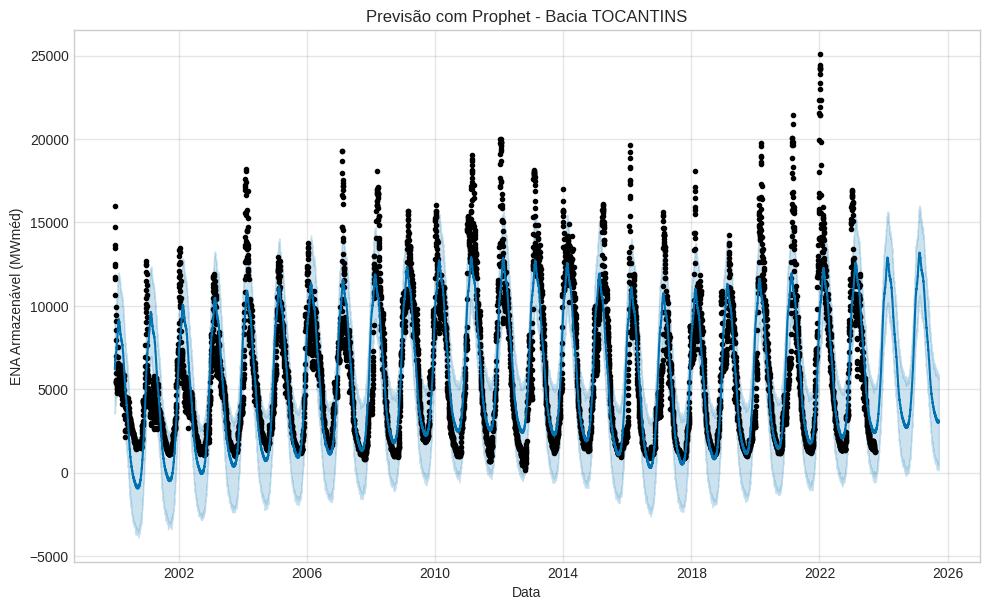


Gerando gráfico comparativo para o período de teste...


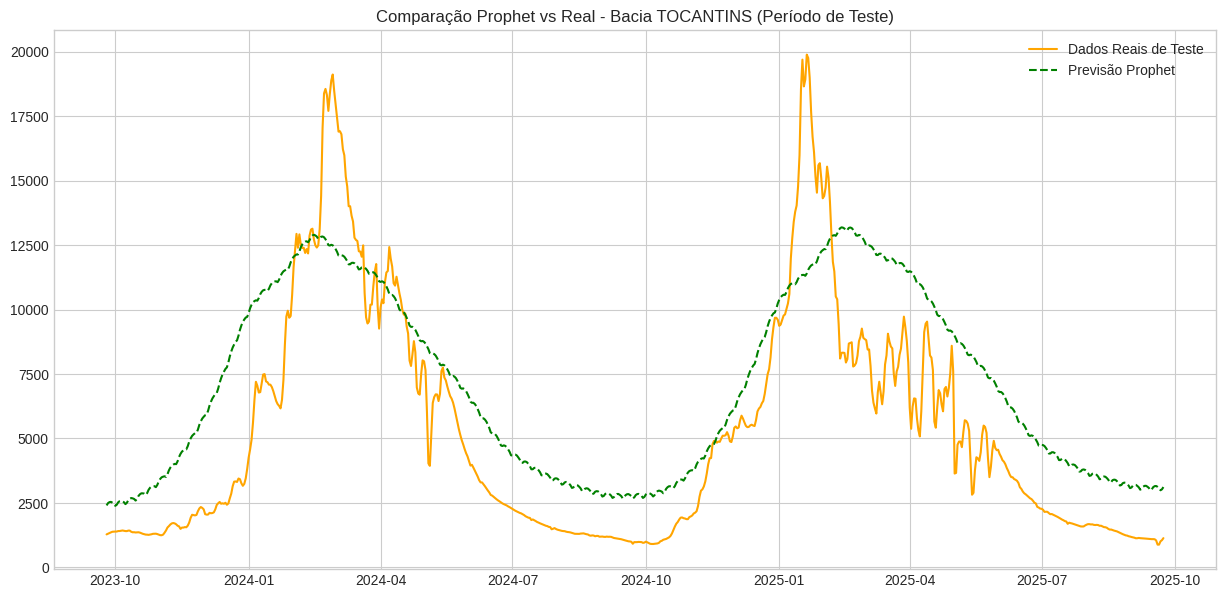

In [31]:
# Célula 13: Preparação dos Dados para o Prophet (com mais dados de treino)
from prophet import Prophet

print("Preparando dados para o modelo Prophet...")
df_prophet = df_bacia.reset_index().rename(columns={'ena_data': 'ds', 'ena_armazenavel': 'y'})

# Divisão Treino/Teste AJUSTADA: Usaremos os últimos 2 anos (730 dias) para teste
teste_periodo_dias = 365 * anos_teste
treino_prophet = df_prophet[:-teste_periodo_dias]
teste_prophet = df_prophet[-teste_periodo_dias:]

print(f"Tamanho do treino (diário): {len(treino_prophet)}")
print(f"Tamanho do teste (diário): {len(teste_prophet)}")

# Célula 14: Treinamento do Modelo Prophet
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
print("\nTreinando o modelo Prophet...")
model_prophet.fit(treino_prophet)

# Célula 15: Previsão e Avaliação do Prophet
future = model_prophet.make_future_dataframe(periods=teste_periodo_dias, freq='D')
forecast_prophet = model_prophet.predict(future)
results_prophet = pd.merge(teste_prophet, forecast_prophet[['ds', 'yhat']], on='ds')

# Métricas
mae_prophet = mean_absolute_error(results_prophet['y'], results_prophet['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(results_prophet['y'], results_prophet['yhat']))
r2_prophet = r2_score(results_prophet['y'], results_prophet['yhat'])
mape_prophet = mean_absolute_percentage_error(results_prophet['y'], results_prophet['yhat']) * 100
acc_prophet = 100 - mape_prophet

print("\n--- Métricas de Avaliação do Modelo Prophet ---")
print(f"R² (Coeficiente de Determinação): {r2_prophet:.4f}")
print(f"Acurácia (100 - MAPE): {acc_prophet:.2f}%")
print(f"MAE (Erro Absoluto Médio): {mae_prophet:.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse_prophet:.2f}\n")

# Célula 16: Visualização do Resultado do Prophet (Gráfico padrão)
print("Gerando gráfico de previsão do Prophet...")
fig1 = model_prophet.plot(forecast_prophet)
plt.title(f'Previsão com Prophet - Bacia {nome_bacia}')
plt.xlabel('Data')
plt.ylabel('ENA Armazenável (MWméd)')
plt.show()

# Célula 16.1: NOVO GRÁFICO - Foco no Período de Teste
print("\nGerando gráfico comparativo para o período de teste...")
plt.figure(figsize=(15, 7))
plt.plot(teste_prophet['ds'], teste_prophet['y'], label='Dados Reais de Teste', color='orange')
plt.plot(results_prophet['ds'], results_prophet['yhat'], label='Previsão Prophet', color='green', linestyle='--')
plt.title(f'Comparação Prophet vs Real - Bacia {nome_bacia} (Período de Teste)')
plt.legend()
plt.show()

7. Modelo 3: LSTM com Dados Mensais


Preparando dados para o modelo LSTM...

Treinando o modelo LSTM...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Gerando previsões com LSTM...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Métricas de Avaliação do Modelo LSTM ---
R² (Coeficiente de Determinação): 0.7646
Acurácia (100 - MAPE): 64.57%
MAE (Erro Absoluto Médio): 1455.48
RMSE (Raiz do Erro Quadrático Médio): 2073.49



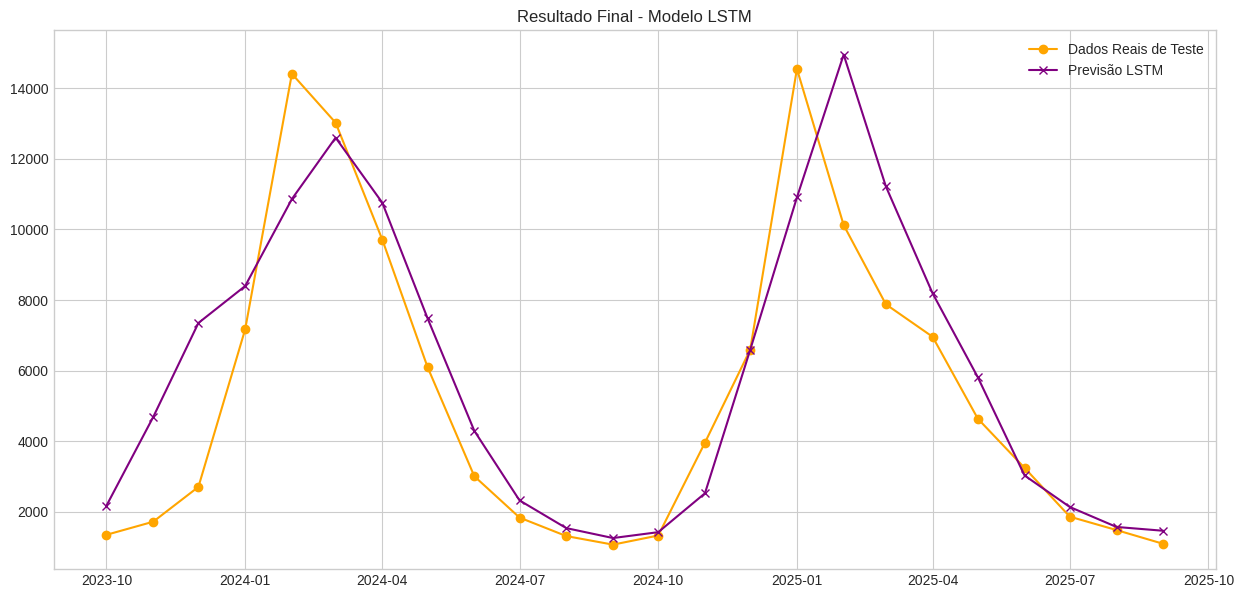

In [36]:
# Célula 17: Preparação dos Dados para a LSTM (com mais dados de treino)
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

print("Preparando dados para o modelo LSTM...")
scaler_lstm = MinMaxScaler()
dados_mensais_scaled = scaler_lstm.fit_transform(df_mensal.to_frame())

# Usaremos os últimos 12 meses (1 ano) para prever o próximo mês
window_size = 12
treino_lstm_scaled = dados_mensais_scaled[:len(treino_mensal)]
teste_lstm_scaled = dados_mensais_scaled[len(treino_mensal)-window_size:]

train_generator = TimeseriesGenerator(treino_lstm_scaled, treino_lstm_scaled, length=window_size, batch_size=16)
test_generator = TimeseriesGenerator(teste_lstm_scaled, teste_lstm_scaled, length=window_size, batch_size=1)

# Célula 18: Construção e Treinamento do Modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(100, activation='relu', input_shape=(window_size, 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

print("\nTreinando o modelo LSTM...")
model_lstm.fit(train_generator, epochs=100, verbose=0)

# Célula 19: Previsão e Avaliação do LSTM
print("\nGerando previsões com LSTM...")
predictions_lstm_scaled = model_lstm.predict(test_generator)
y_pred_lstm = scaler_lstm.inverse_transform(predictions_lstm_scaled)
y_test_lstm = teste_mensal.values.reshape(-1, 1)

# Métricas
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)
mape_lstm = mean_absolute_percentage_error(y_test_lstm, y_pred_lstm) * 100
acc_lstm = 100 - mape_lstm

print("\n--- Métricas de Avaliação do Modelo LSTM ---")
print(f"R² (Coeficiente de Determinação): {r2_lstm:.4f}")
print(f"Acurácia (100 - MAPE): {acc_lstm:.2f}%")
print(f"MAE (Erro Absoluto Médio): {mae_lstm:.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse_lstm:.2f}\n")

# Célula 20: Visualização do Resultado do LSTM
plt.figure(figsize=(15, 7))
plt.plot(teste_mensal.index, y_test_lstm, label='Dados Reais de Teste', color='orange', marker='o')
plt.plot(teste_mensal.index, y_pred_lstm, label='Previsão LSTM', color='purple', marker='x')
plt.title('Resultado Final - Modelo LSTM')
plt.legend()
plt.show()

8. Comparação Final dos Modelos


In [34]:
# Célula 21: Compilando os resultados finais
metrics_sarima['Acurácia (100 - MAPE)'] = acc_sarima
metrics_prophet['Acurácia (100 - MAPE)'] = acc_prophet
metrics_lstm['Acurácia (100 - MAPE)'] = acc_lstm

df_comparison = pd.DataFrame({
    'SARIMA (Mensal)': metrics_sarima,
    'Prophet (Diário)': metrics_prophet,
    'LSTM (Mensal)': metrics_lstm
}).T

# Reordenar colunas para melhor visualização
df_comparison = df_comparison[['R²', 'Acurácia (100 - MAPE)', 'MAE', 'RMSE']]

print("--- Tabela Comparativa de Métricas ---")
display(df_comparison.sort_values(by='R²', ascending=False))

NameError: name 'metrics_sarima' is not defined

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 26.3 MB/s eta 0:00:00
Bibliotecas importadas com sucesso!
Conectado ao projeto: sauter-university-472416
Dados carregados com sucesso do BigQuery!

Análise focada na bacia: PARANAPANEMA
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9398 entries, 2000-01-01 to 2025-09-23
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ena_armazenavel  9398 non-null   float64
dtypes: float64(1)
memory usage: 146.8 KB
None


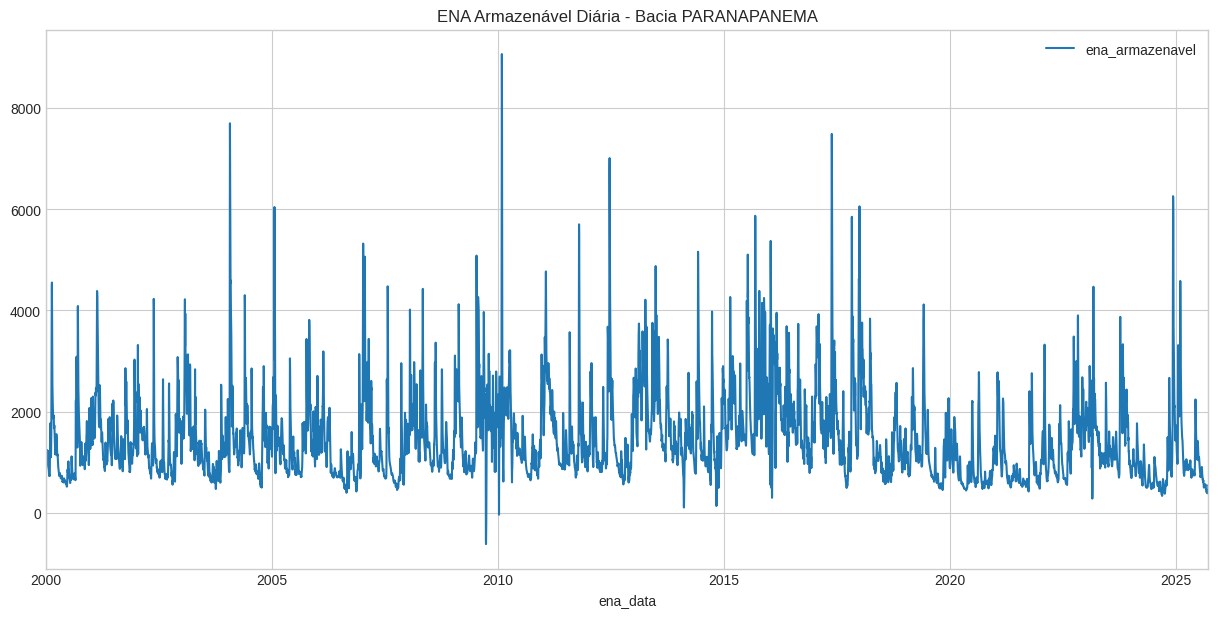

Iniciando a criação de features para o modelo LSTM...
Features para LSTM criadas com sucesso.
Número de features: 15


,ena_armazenavel,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3,sin_4,cos_4,lag_7,lag_14,lag_30,lag_60,rolling_mean_7,rolling_mean_30
ena_data,,,,,,,,,,,,,,,
2000-03-01,1865.029053,0.867099,0.498137,0.863867,-0.503720,-0.006451,-0.999979,-0.870294,-0.492533,2355.216064,4119.016113,728.992981,843.882996,2000.848737,2188.281624
2000-03-02,1905.522949,0.875539,0.483147,0.846029,-0.533137,-0.058026,-0.998315,-0.902099,-0.431530,2248.392090,4448.368164,835.880981,884.921021,1951.867432,2223.936357
2000-03-03,1924.563965,0.883720,0.468015,0.827189,-0.561923,-0.109446,-0.993993,-0.929634,-0.368484,2123.977051,4551.764160,1219.579956,898.987976,1923.379848,2247.435824
2000-03-04,1831.728027,0.891640,0.452745,0.807371,-0.590044,-0.160575,-0.987024,-0.952769,-0.303695,2033.519043,3976.487061,1461.531982,913.828003,1894.552560,2259.775692
2000-03-05,1716.119995,0.899296,0.437340,0.786597,-0.617467,-0.211276,-0.977426,-0.971395,-0.237468,1959.740967,3296.605957,1586.418945,997.536987,1859.749564,2264.099060



Shape de X_train (amostras, janela, features): (8428, 180, 15)
Shape de X_test (amostras, janela, features): (730, 180, 15)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 180, 100)       │        46,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 180, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,651 (299.42 KB)

 Trainable params: 76,651 (299.42 KB)

 Non-trainable params: 0 (0.00 B)

None

Iniciando treinamento com 30 épocas...
Epoch 1/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 66s 474ms/step - loss: 0.0122 - val_loss: 0.0035
Epoch 2/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 43s 323ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 3/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 82s 325ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 4/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 84s 338ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 5/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 80s 323ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 6/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 333ms/step - loss: 0.0019 - val_loss: 8.3807e-04
Epoch 7/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 43s 323ms/step - loss: 0.0018 - val_loss: 8.5083e-04
Epoch 8/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 42s 321ms/step - loss: 0.0015 - val_loss: 5.0255e-04
Epoch 9/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 82s 322ms/step - loss: 0.0012 - val_loss: 4.0273e-04
Epoch 10/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 43s 326ms/step - loss: 0.0011 - val_loss: 3.6770e-04
Epoch 11/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s

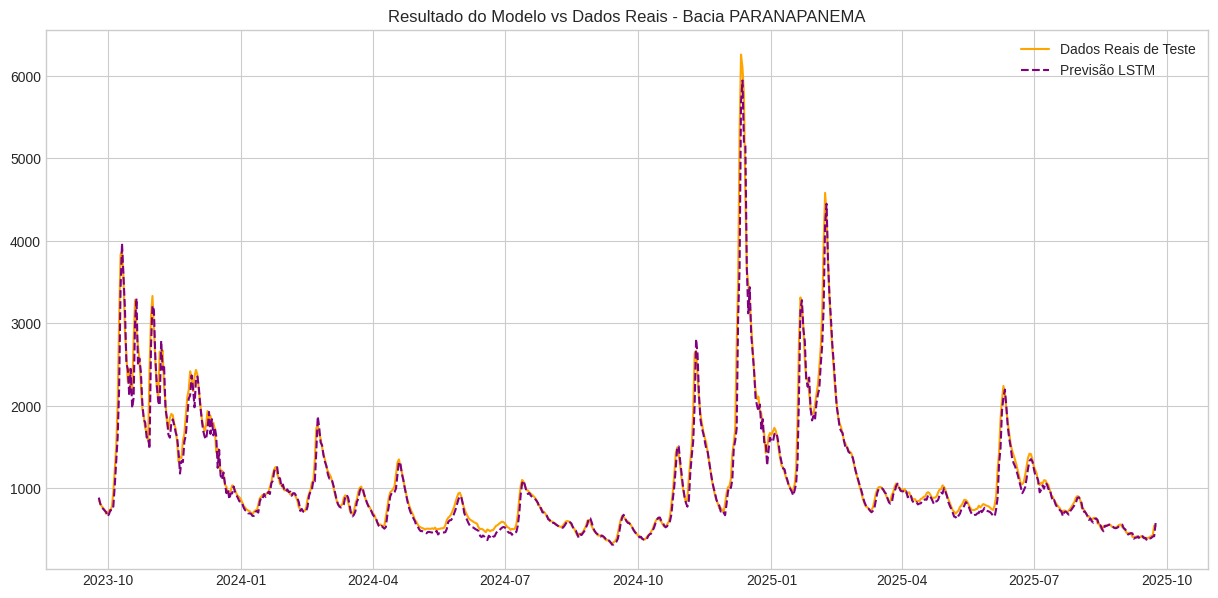

In [1]:
# CÉLULA 1: INSTALAÇÃO DE BIBLIOTECAS
# -------------------------------------
# Garante que todas as bibliotecas necessárias estão instaladas.
!pip install statsmodels optuna tensorflow

# CÉLULA 2: IMPORTAÇÃO DAS BIBLIOTECAS
# ------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery

# Ferramentas de Machine Learning e Deep Learning
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Métricas de avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configurações de visualização para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)
print("Bibliotecas importadas com sucesso!")


# CÉLULA 3: CONEXÃO COM O GOOGLE BIGQUERY
# ---------------------------------------
from google.colab import auth
auth.authenticate_user()

project_id = 'sauter-university-472416' # Substitua se o seu project_id for diferente
client = bigquery.Client(project=project_id)
print(f"Conectado ao projeto: {project_id}")


# CÉLULA 4: CARREGAMENTO DOS DADOS
# ---------------------------------
sql_query = """
SELECT
    nom_bacia,
    ena_data,
    ena_armazenavel_bacia_mwmed
FROM
    `sauter-university-472416.ons_silver.ena_basin_silver`
ORDER BY
    ena_data
"""
df_total = client.query(sql_query).to_dataframe()
print("Dados carregados com sucesso do BigQuery!")


# CÉLULA 5: PREPARAÇÃO INICIAL DOS DADOS
# --------------------------------------
# Converter a coluna de data para o formato datetime e definir como índice
df_total['ena_data'] = pd.to_datetime(df_total['ena_data'])
df_total.set_index('ena_data', inplace=True)
df_total.sort_index(inplace=True)

# Converter a coluna alvo para numérico
df_total['ena_armazenavel_bacia_mwmed'] = pd.to_numeric(df_total['ena_armazenavel_bacia_mwmed'], errors='coerce')

# Selecionar a bacia para o modelo e tratar valores nulos
nome_bacia = 'PARANAPANEMA' # Você pode alterar a bacia aqui
df_bacia = df_total[df_total['nom_bacia'] == nome_bacia].copy()
df_bacia = df_bacia[['ena_armazenavel_bacia_mwmed']].rename(columns={'ena_armazenavel_bacia_mwmed': 'ena_armazenavel'})
df_bacia.ffill(inplace=True) # Preenche valores nulos com o último valor válido

print(f"\nAnálise focada na bacia: {nome_bacia}")
print(df_bacia.info())
df_bacia.plot(title=f'ENA Armazenável Diária - Bacia {nome_bacia}')
plt.show()


# CÉLULA 6: ENGENHARIA DE FEATURES PARA O MODELO LSTM
# ----------------------------------------------------
print("Iniciando a criação de features para o modelo LSTM...")
df_lstm = df_bacia.copy()

# Features de Fourier para Sazonalidade
day_of_year = df_lstm.index.dayofyear
for k in range(1, 5):
    df_lstm[f'sin_{k}'] = np.sin(2 * np.pi * k * day_of_year / 365.25)
    df_lstm[f'cos_{k}'] = np.cos(2 * np.pi * k * day_of_year / 365.25)

# Features de Lag (valores passados)
for lag in [7, 14, 30, 60]:
    df_lstm[f'lag_{lag}'] = df_lstm['ena_armazenavel'].shift(lag)

# Features de Média Móvel
for window in [7, 30]:
    df_lstm[f'rolling_mean_{window}'] = df_lstm['ena_armazenavel'].rolling(window=window).mean()

df_lstm.dropna(inplace=True)
print("Features para LSTM criadas com sucesso.")
print(f"Número de features: {df_lstm.shape[1]}")
display(df_lstm.head())


# CÉLULA 7: PREPARAÇÃO FINAL E DIVISÃO TREINO/TESTE
# ------------------------------------------------
# Normalização Min-Max
scaler_lstm = MinMaxScaler()
dados_scaled = scaler_lstm.fit_transform(df_lstm)

# Divisão Treino/Teste
anos_teste = 2
dias_teste = 365 * anos_teste
treino_scaled = dados_scaled[:-dias_teste]
teste_scaled = dados_scaled[-dias_teste:]

# Função para criar as janelas de dados (sequências)
def create_sequences(data, target_data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(target_data[i + window_size])
    return np.array(X), np.array(y)

# PARÂMETRO DA JANELA DE TEMPO
window_size = 180 # Janela de 180 dias
X_train, y_train = create_sequences(treino_scaled, treino_scaled[:, 0], window_size)

# Para o teste, pegamos o final do treino para começar as previsões
input_teste = np.concatenate([treino_scaled[-window_size:], teste_scaled])
X_test, y_test_scaled = create_sequences(input_teste, input_teste[:, 0], window_size)

print(f"\nShape de X_train (amostras, janela, features): {X_train.shape}")
print(f"Shape de X_test (amostras, janela, features): {X_test.shape}")


# CÉLULA 8: CONSTRUÇÃO E TREINAMENTO DO MODELO LSTM
# -------------------------------------------------
# ==========================================================
# PARÂMETROS DE TREINAMENTO (Altere aqui se quiser testar!)
# ==========================================================
NUM_EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 0.001
# ==========================================================

model_lstm = Sequential()
model_lstm.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model_lstm.compile(optimizer=optimizer, loss='mse')
print(model_lstm.summary())

print(f"\nIniciando treinamento com {NUM_EPOCHS} épocas...")
history = model_lstm.fit(X_train, y_train,
                         epochs=NUM_EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(X_test, y_test_scaled),
                         verbose=1)


# CÉLULA 9: AVALIAÇÃO DO MODELO NO CONJUNTO DE TESTE
# --------------------------------------------------
print("\nGerando previsões no conjunto de teste para avaliação...")
predictions_lstm_scaled = model_lstm.predict(X_test)

# Inverter a escala para comparar com os valores originais
dummy_array_pred = np.zeros((len(predictions_lstm_scaled), dados_scaled.shape[1]))
dummy_array_pred[:, 0] = predictions_lstm_scaled.flatten()
dummy_array_pred[:, 1:] = X_test[:, -1, 1:]
y_pred_lstm = scaler_lstm.inverse_transform(dummy_array_pred)[:, 0]

dummy_array_test = np.zeros((len(y_test_scaled), dados_scaled.shape[1]))
dummy_array_test[:, 0] = y_test_scaled.flatten()
dummy_array_test[:, 1:] = X_test[:, -1, 1:]
y_test_lstm_original = scaler_lstm.inverse_transform(dummy_array_test)[:, 0]

# Cálculo das Métricas
mae_lstm = mean_absolute_error(y_test_lstm_original, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_original, y_pred_lstm))
r2_lstm = r2_score(y_test_lstm_original, y_pred_lstm)
mape_lstm = np.mean(np.abs((y_test_lstm_original - y_pred_lstm) / np.where(y_test_lstm_original == 0, 1, y_test_lstm_original))) * 100
acc_lstm = 100 - mape_lstm

print("\n--- Métricas de Avaliação do Modelo LSTM (no Período de Teste) ---")
print(f"R²: {r2_lstm:.4f}")
print(f"Acurácia (100 - MAPE): {acc_lstm:.2f}%")
print(f"MAE: {mae_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}\n")


# CÉLULA 10: VISUALIZAÇÃO DOS RESULTADOS NO CONJUNTO DE TESTE
# -----------------------------------------------------------
# Criar o DataFrame com as previsões para plotar
teste_df_original = df_lstm[-dias_teste:]
df_pred_lstm = pd.DataFrame(y_pred_lstm, index=teste_df_original.index, columns=['Previsão LSTM'])

plt.figure(figsize=(15, 7))
plt.plot(teste_df_original['ena_armazenavel'], label='Dados Reais de Teste', color='orange')
plt.plot(df_pred_lstm, label='Previsão LSTM', color='purple', linestyle='--')
plt.title(f'Resultado do Modelo vs Dados Reais - Bacia {nome_bacia}')
plt.legend()
plt.show()

Gerando gráfico completo com dados de treino e teste...


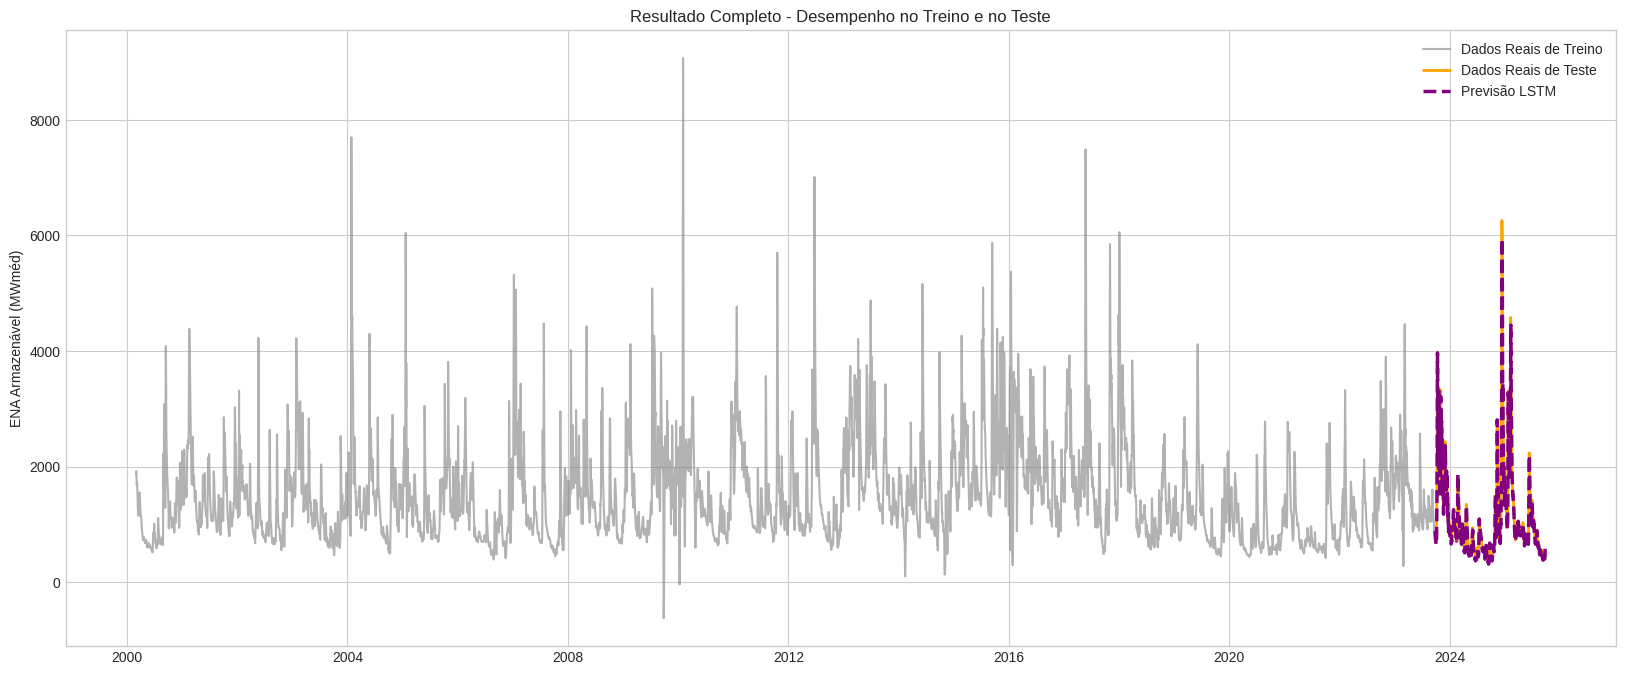

In [7]:
# CÉLULA DE VISUALIZAÇÃO COMPLETA (TREINO + TESTE) - VERSÃO CORRIGIDA
# --------------------------------------------------------------------

print("Gerando gráfico completo com dados de treino e teste...")

plt.figure(figsize=(20, 8))

# 1. Plotar os dados de treino para dar contexto
# Usamos o df_lstm original e selecionamos a parte de treino
dados_de_treino_reais = df_lstm[:-dias_teste]
plt.plot(dados_de_treino_reais['ena_armazenavel'], label='Dados Reais de Treino', color='gray', alpha=0.6)

# 2. Plotar os dados reais de teste
dados_de_teste_reais = df_lstm[-dias_teste:]
plt.plot(dados_de_teste_reais['ena_armazenavel'], label='Dados Reais de Teste', color='orange', linewidth=2)

# 3. Plotar a previsão para o período de teste (essa parte já estava certa)
plt.plot(df_pred_lstm, label='Previsão LSTM', color='purple', linestyle='--', linewidth=2.5)

plt.title('Resultado Completo - Desempenho no Treino e no Teste')
plt.ylabel('ENA Armazenável (MWméd)')
plt.legend()
plt.show()

In [2]:
# CÉLULA FINAL: SALVAR O MODELO E O SCALER PARA DEPLOY
# ----------------------------------------------------
import joblib
from google.colab import files

# 1. Definir os nomes dos arquivos
model_filename = 'modelo_ena_lstm.keras'
scaler_filename = 'scaler_ena.pkl'

# 2. Salvar o modelo treinado no formato Keras
# Este comando salva a arquitetura, os pesos e o estado do otimizador.
model_lstm.save(model_filename)
print(f"Modelo salvo com sucesso como '{model_filename}'")

# 3. Salvar o objeto scaler usando a biblioteca joblib
# Isso salva o objeto que sabe como normalizar e desnormalizar seus dados.
joblib.dump(scaler_lstm, scaler_filename)
print(f"Scaler salvo com sucesso como '{scaler_filename}'")

# 4. Baixar os arquivos para o seu computador local
# Ao executar esta parte, o Colab vai pedir para você autorizar o download.
print("\nIniciando o download dos arquivos para o seu computador...")
files.download(model_filename)
files.download(scaler_filename)
print("Download concluído!")

Modelo salvo com sucesso como 'modelo_ena_lstm.keras'
Scaler salvo com sucesso como 'scaler_ena.pkl'

Iniciando o download dos arquivos para o seu computador...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download concluído!
